# Exploring HECKTOR Dataset

In [1]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import torch
import os

### Data Paths

In [2]:
# Defining data paths:
MODE = "train_data"

if MODE == "test_data":
    imagePath = '/home/jakub/research/HECKTOR/Data/raw_data/hecktor2022/hecktor2022_testing/imagesTs_resampled/'
    maskPath = '/home/jakub/research/HECKTOR/Data/raw_data/hecktor2022/hecktor2022_testing/labelsTs_resampled/'
    clinical_df = pd.read_csv("/home/jakub/research/HECKTOR/Data/raw_data/hecktor2022/hecktor2022_testing/hecktor2022_clinical_info_testing.csv")
    endpoint = pd.read_csv("/home/jakub/research/HECKTOR/Data/raw_data/hecktor2022/hecktor2022_testing/hecktor2022_endpoint_testing.csv")
    CENTROID_DATA_PATH = '/home/jakub/research/HECKTOR/Data/centroid/test_data'
    BBOX_DATA_PATH = '/home/jakub/research/HECKTOR/Data/bbox/test_data'
elif MODE == "train_data":
    imagePath = '/home/jakub/research/HECKTOR/Data/raw_data/hecktor2022/hecktor2022_training/imagesTr_resampled/'
    maskPath = '/home/jakub/research/HECKTOR/Data/raw_data/hecktor2022/hecktor2022_training/labelsTr_resampled/'
    clinical_df = pd.read_csv("/home/jakub/research/HECKTOR/Data/raw_data/hecktor2022/hecktor2022_training/hecktor2022_patient_info_training.csv")
    endpoint = pd.read_csv("/home/jakub/research/HECKTOR/Data/raw_data/hecktor2022/hecktor2022_training/hecktor2022_patient_endpoint_training.csv")
    CENTROID_DATA_PATH = '/home/jakub/research/HECKTOR/Data/centroid/train_data'
    BBOX_DATA_PATH = '/home/jakub/research/HECKTOR/Data/bbox/train_data'

## Visualization of Raw Data

### Tabular data
Table containing clinical informations about patients.

In [3]:
clinical_df.head()

,PatientID,CenterID,Gender,Age,Tobacco,Alcohol,Performance_status,"HPV status (0=-, 1=+)",Surgery,Chemotherapy
0,CHUM-001,1,M,82,NaN,NaN,NaN,NaN,NaN,1
1,CHUM-002,1,M,73,NaN,NaN,NaN,NaN,NaN,1
2,CHUM-006,1,M,65,NaN,NaN,NaN,NaN,NaN,1
3,CHUM-007,1,F,70,NaN,NaN,NaN,NaN,NaN,0
4,CHUM-008,1,F,67,NaN,NaN,NaN,NaN,NaN,1


Table containing target RFS (Recurrence-Free Survival) values and information about relapse event. RFS is time to event, where event might be cancer relapse (1) or censoring (0) like death.

In [4]:
endpoint.head()

,PatientID,Relapse,RFS
0,CHUM-001,0,1704
1,CHUM-002,1,439
2,CHUM-006,0,1186
3,CHUM-007,0,1702
4,CHUM-008,0,1499


### Visualization of variables
First of all, let's visualise histogram of RFS and Relapse.

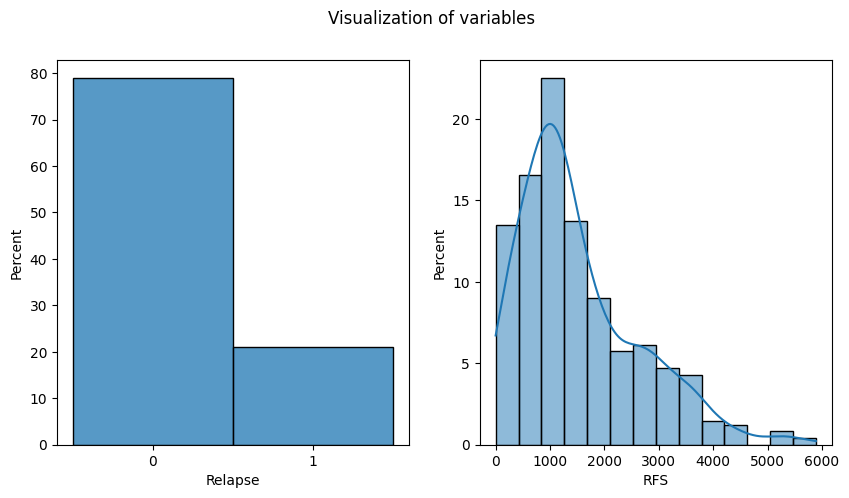

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

# Distribution of censored and non-censored examples.
bins = [-0.5, 0.5, 1.5]
sns.histplot(endpoint,
             x="Relapse",
             kde=False,
             bins=bins,
             stat="percent",
             ax=axs[0])
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['0', '1'])

# Distribution of RFS.
sns.histplot(endpoint,
             x="RFS",
             kde=True,
             bins=14,
             stat="percent",
             ax=axs[1])

plt.suptitle("Visualization of variables")
plt.show()

It would be beneficial to visualise RFS divided into censored and non-censored examples.

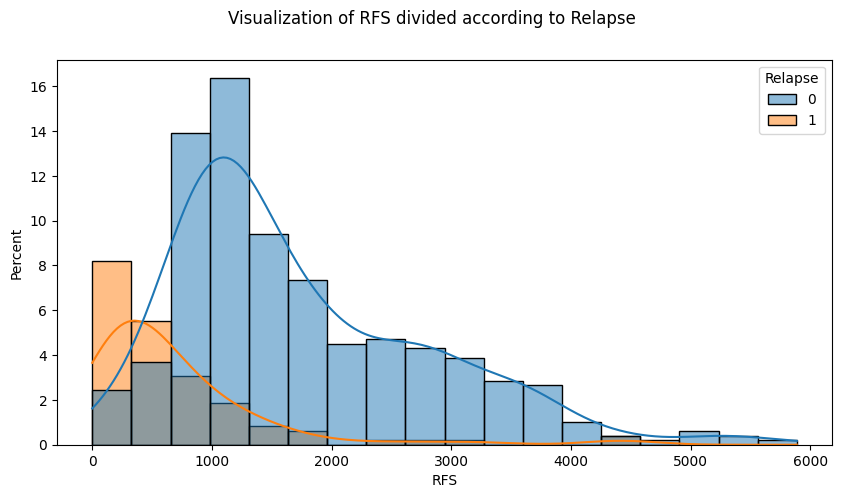

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Distribution of RFS.
sns.histplot(endpoint,
             x="RFS",
             kde=True,
             bins=18,
             stat="percent",
             ax=ax,
             hue="Relapse")

plt.suptitle("Visualization of RFS divided according to Relapse")

plt.show()

### Raw Images Visualization

In [7]:
def load_images(IDs):
    print("Loading images ...")
    data = {}
    for id in tqdm(IDs):
        labelPath = os.path.join(maskPath, id + '.nii.gz')
        ctPath = os.path.join(imagePath, id + '__CT.nii.gz')
        petPath = os.path.join(imagePath, id + '__PT.nii.gz')
        mask = sitk.ReadImage(labelPath)
        CT = sitk.ReadImage(ctPath)
        PET = sitk.ReadImage(petPath)
        mask = sitk.GetArrayFromImage(mask)
        CT = sitk.GetArrayFromImage(CT)
        PET = sitk.GetArrayFromImage(PET)
        data[id] = (CT, PET, mask)
    return data

In [8]:
# Patient IDs
ids = clinical_df['PatientID'].to_list()
print(ids[:5])
exemplary_data = load_images(ids[:5])

['CHUM-001', 'CHUM-002', 'CHUM-006', 'CHUM-007', 'CHUM-008']
Loading images ...


100%|██████████| 5/5 [00:01<00:00,  3.59it/s]


In [9]:
def visualize_raw_data(data, patient_ID, slice_):
    CT, PET, mask = data[patient_ID]
    ct_img = CT[slice_, :, :]
    pet_img = PET[slice_, :, :]
    mask_img = mask[slice_, :, :]

    print(f"CT shape: {CT.shape}")
    print(f"PET shape: {PET.shape}")
    print(f"mask shape: {mask.shape}")

    fig, axs = plt.subplots(2, 2, figsize=(8, 8))

    # CT
    axs[0, 0].imshow(ct_img, cmap='gray')
    axs[0, 0].set_title("CT")

    # PET
    axs[0, 1].imshow(pet_img, cmap='gray')
    axs[0, 1].set_title("PET")

    # Merged CT/PET
    axs[1, 0].imshow(ct_img, cmap='gray')
    axs[1, 0].imshow(pet_img, cmap='hot', alpha=0.4)
    axs[1, 0].set_title("CT + PET overlay")

    # CT with mask
    axs[1, 1].imshow(ct_img, cmap='gray')
    axs[1, 1].imshow(mask_img, cmap='Reds', alpha=0.3)
    axs[1, 1].set_title("CT + Mask overlay")

    # Custom legend for mask classes
    import matplotlib.patches as mpatches
    legend_patches = [
        mpatches.Patch(color='red', label='1: GTVp'),
        mpatches.Patch(color='#800000', label='2: GTVn')
    ]
    axs[1, 1].legend(handles=legend_patches, loc='lower right', fontsize='small', frameon=True)


    for ax_row in axs:
        for ax in ax_row:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

CT shape: (149, 225, 225)
PET shape: (149, 225, 225)
mask shape: (149, 225, 225)


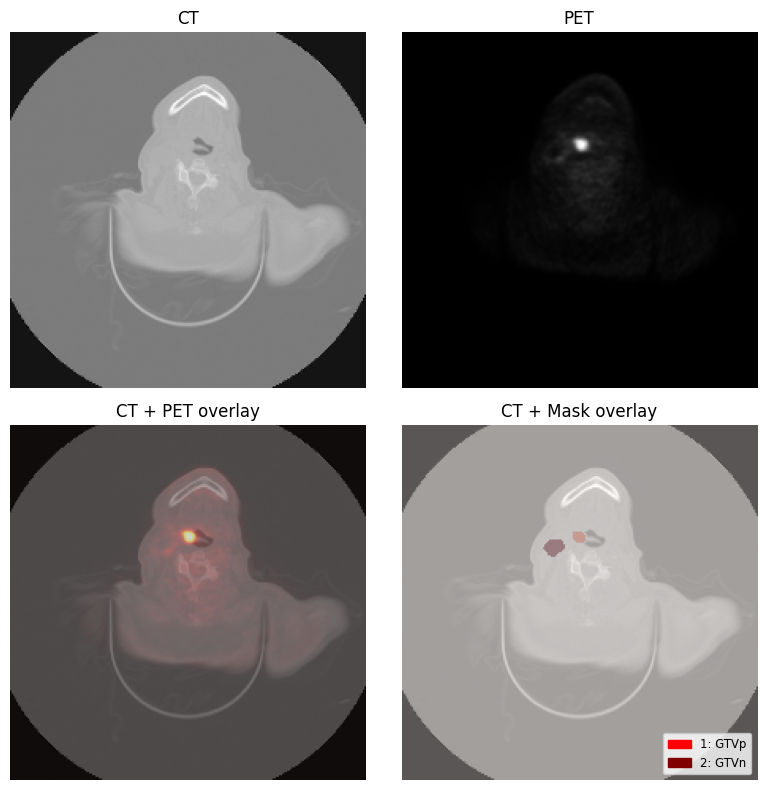

In [10]:
visualize_raw_data(exemplary_data, ids[0], 45)

## Visualization of Preprocessed Data
Data consist on PET, CT images and mask with the following labels: 0, 1, 2.
Where:
* 0 -> background, 
* 1 -> GTVp (primary Gross Tumor Volume)
* 2 -> GTVn (Nodal Gross Tumor Volume)

In my preprocessing I focused purely on GTVp annotations and I extracted volumes arround tumor according to GTVp mask.
To extract volumes I applied two approaches:
* centroid-based -> In this approach I extract a volume arround geometric center of tumor annotation. Volume is parametrized with parameter margin: `m`. 
* bbox-based -> In this approach I extract full bbox padded additionaly with `p` voxels.

In [11]:
def visualize_cropped_data(ID: str, slice_: int, directory: str):
    CT = torch.load(os.path.join(directory, "crops_CT", f"{ID}.pt"), weights_only=False).numpy()
    PET = torch.load(os.path.join(directory, "crops_PET", f"{ID}.pt"), weights_only=False).numpy()
    MASK = torch.load(os.path.join(directory, "crops_mask", f"{ID}.pt"), weights_only=False).numpy()

    print(f"CT shape: {CT.shape}")
    print(f"PET shape: {PET.shape}")
    print(f"Mask shape: {MASK.shape}")

    ct_img = CT[slice_, :, :]
    pet_img = PET[slice_, :, :]
    mask_img = MASK[slice_, :, :]

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # CT
    axs[0, 0].imshow(ct_img, cmap='gray')
    axs[0, 0].set_title("CT")

    # PET
    axs[0, 1].imshow(pet_img, cmap='gray')
    axs[0, 1].set_title("PET")

    # Merged CT/PET
    axs[1, 0].imshow(ct_img, cmap='gray')
    axs[1, 0].imshow(pet_img, cmap='hot', alpha=0.4)
    axs[1, 0].set_title("CT + PET overlay")

    # CT with mask
    axs[1, 1].imshow(ct_img, cmap='gray')
    axs[1, 1].imshow(mask_img, cmap='Reds', alpha=0.3, vmin=0, vmax=2)
    axs[1, 1].set_title("CT + Mask overlay")

    # Custom legend for mask classes
    import matplotlib.patches as mpatches
    legend_patches = [
        mpatches.Patch(color='red', label='1: GTVp'),
        mpatches.Patch(color='#800000', label='2: GTVn')
    ]
    axs[1, 1].legend(handles=legend_patches, loc='lower right', fontsize='small', frameon=True)

    for ax_row in axs:
        for ax in ax_row:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

### Centroid Based preprocessing

CT shape: (60, 60, 60)
PET shape: (60, 60, 60)
Mask shape: (60, 60, 60)


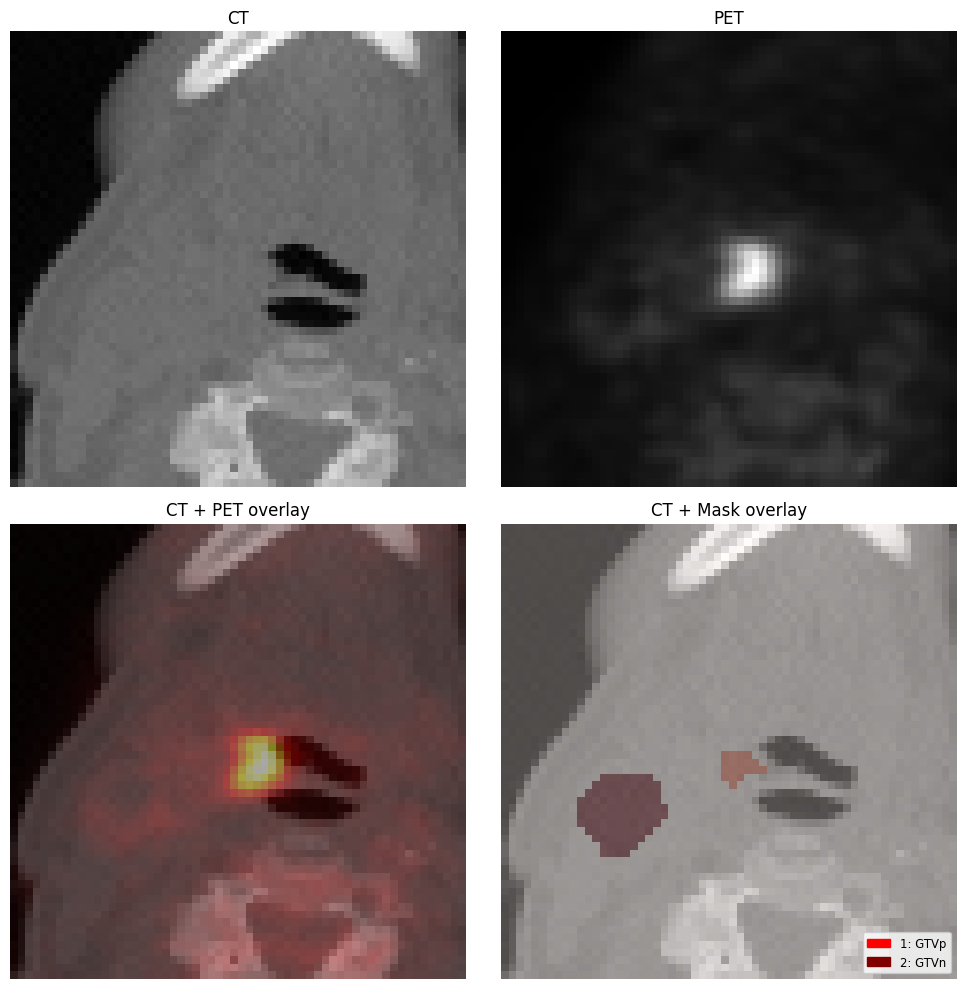

In [12]:
visualize_cropped_data(ids[0], slice_=20, directory=CENTROID_DATA_PATH)

### BBOX Based Preprocessing

CT shape: (40, 30, 33)
PET shape: (40, 30, 33)
Mask shape: (40, 30, 33)


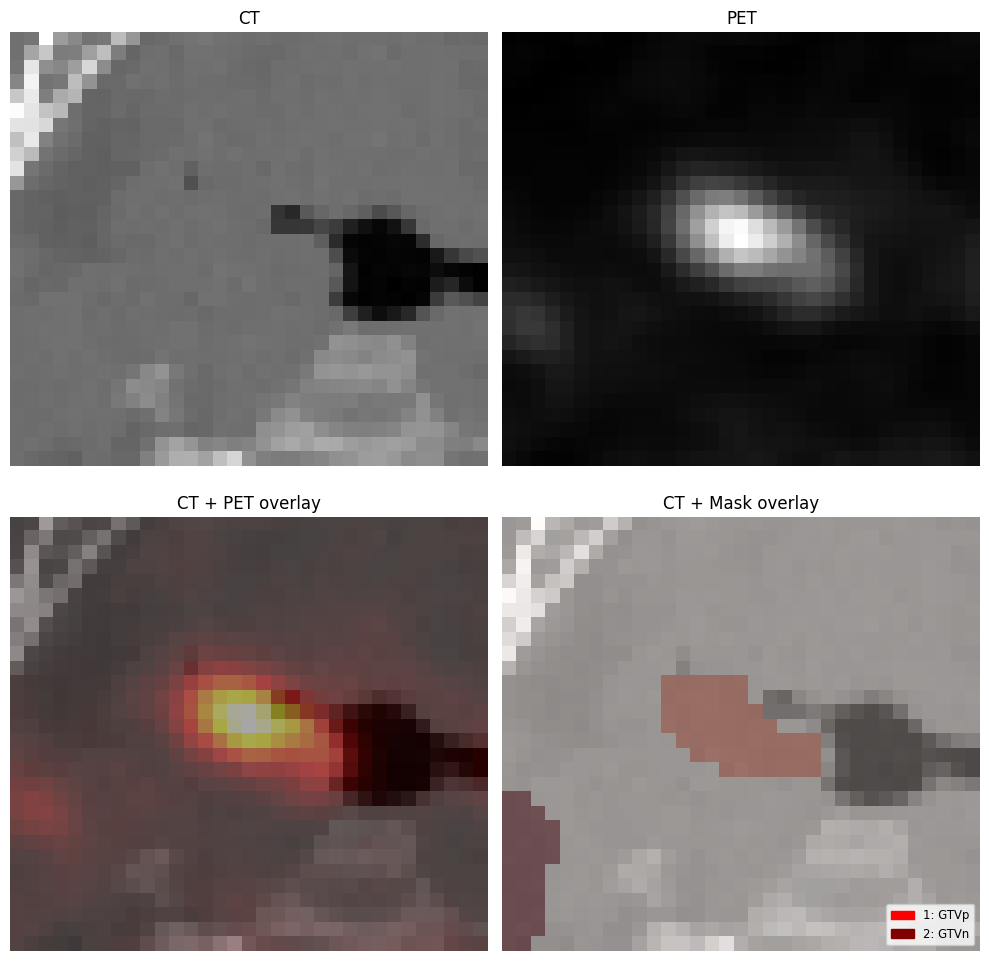

In [13]:
visualize_cropped_data(ids[0], slice_=20, directory=BBOX_DATA_PATH)